# Proyecto Modelación y Simulación

#### Francis Aguilar 22243
#### Diego García    22404
#### Ángela García   22869

Usando un modelo basado en agentes, sobre una red sintética, se simulará el crecimiento y el colapso de una estafa piramidal, impulsada por el reclutamiento. Cada agente debería invertir o reclutar según su credibilidad y éxito local.

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Reproducibilidad
random.seed(42)
np.random.seed(42)

# Parámetros
params = {
    "N_AGENTES": 500,                   # Cantidad de agentes
    "GRADO_MEDIO": 3,                   # Conectividad de la red
    "NUM_PROMOTORES_INICIALES": 3,
    "INVERSION": 100.0,                 # Monto que invierte cada nuevo participante
    "RETORNO": 0.10,                    # Retorno prometido por periodo, según lo invertido
    "COMISION": 0.20,                   # Comisión para el reclutador, según la inversión del reclutado
    "P_BASE": 0.25,                     # Probabilidad inicial de convencer a otro
    "PASOS_MAX": 100,                   # Paso máximo de simulación
    "PASOS_SIN_NUEVOS_PARA_COLAPSO": 3  # Cuántos pasos sin nuevos tonotos que se metan a la estafa para que colapse
}

In [3]:
# Crear la red sintética
G = nx.barabasi_albert_graph(
    n=params["N_AGENTES"],
    m=params["GRADO_MEDIO"]
)

# Inicializar atributos de los agentes
for n in G.nodes:
    G.nodes[n].update({
        "estado": "ignorante",      # "ignorante", "participante", "promotor"
        "credibilidad": np.random.uniform(0.2, 0.8),
        "invertido": 0.0,
        "ganancia": 0.0,            # ganancia neta
        "reclutados": 0,            # número de agentes que ha reclutado
        "paso_union": None,         # en qué paso entró a la estafa
        "reclutador": None          # quién lo reclutó
    })

# Escoger promotores iniciales de entre los agentes
promotores_iniciales = random.sample(list(G.nodes), params["NUM_PROMOTORES_INICIALES"])

for p in promotores_iniciales:
    G.nodes[p]["estado"] = "promotor"
    # El promotor inicial invierte para "activar" la estafa
    G.nodes[p]["invertido"] = params["INVERSION"]
    G.nodes[p]["ganancia"] = -params["INVERSION"]
    G.nodes[p]["paso_union"] = 0

# Estado global de la estafa
state = {
    "t": 0,
    "colapsado": False
}

# Historial para análisis
history = {
    "t": [],
    "n_participantes": [],
    "n_promotores": [],
    "n_nuevos": [],
    "total_invertido": [],
    "ganancia_total": [],
    "colapsado": []
}

def registrar_estado():
    """Guardar métricas globales en cada paso."""
    participantes = [n for n, a in G.nodes(data=True)
                     if a["estado"] in ("participante", "promotor")]
    n_promotores = sum(1 for _, a in G.nodes(data=True) if a["estado"] == "promotor")
    total_invertido = sum(a["invertido"] for _, a in G.nodes(data=True))
    ganancia_total = sum(a["ganancia"] for _, a in G.nodes(data=True))

    history["t"].append(state["t"])
    history["n_participantes"].append(len(participantes))
    history["n_promotores"].append(n_promotores)
    history["n_nuevos"].append(0)
    history["total_invertido"].append(total_invertido)
    history["ganancia_total"].append(ganancia_total)
    history["colapsado"].append(state["colapsado"])

# Registrar el estado inicial (t = 0)
registrar_estado()


In [4]:
# Probabilidad de reclutamiento
# Depende de la credibilidad del promotor y del éxito local
def prob_reclutamiento(promotor, vecino):
    a = G.nodes[promotor]
    vecinos_promotor = list(G.neighbors(promotor))
    exito_local = a["reclutados"] / max(1, len(vecinos_promotor))

    # Mezclamos factores: base * (1 + credibilidad) * (0.5 + éxito_local)
    p = params["P_BASE"] * (0.5 + a["credibilidad"]) * (0.5 + exito_local)
    return float(np.clip(p, 0.0, 1.0))

# Todo lo que ocurre en un paso de la simulación
def step():
    if state["colapsado"]:
        return  # No hacer nada si ya colapsó

    t = state["t"]
    nuevos = []

    # 1. Reclutamiento: cada promotor intenta convencer a vecinos ignorantes
    promotores = [n for n, a in G.nodes(data=True) if a["estado"] == "promotor"]

    for p in promotores:
        vecinos = list(G.neighbors(p))
        candidatos = [v for v in vecinos if G.nodes[v]["estado"] == "ignorante"]
        if not candidatos:
            continue

        for v in candidatos:
            p_recl = prob_reclutamiento(p, v)
            if np.random.rand() < p_recl:
                # El reclutado invierte
                G.nodes[v]["estado"] = "participante"
                G.nodes[v]["invertido"] = params["INVERSION"]
                G.nodes[v]["ganancia"] = -params["INVERSION"]
                G.nodes[v]["paso_union"] = t
                G.nodes[v]["reclutador"] = p
                nuevos.append(v)

                # Le da comisión al promotor
                G.nodes[p]["ganancia"] += params["COMISION"] * params["INVERSION"]
                G.nodes[p]["reclutados"] += 1

    # 2. Pagar retornos a participantes previos
    inversion_nueva = len(nuevos) * params["INVERSION"]
    participantes_previos = [
        n for n, a in G.nodes(data=True)
        if a["estado"] in ("participante", "promotor") and a["paso_union"] is not None and a["paso_union"] < t
    ]
    monto_prometido = params["RETORNO"] * sum(G.nodes[n]["invertido"] for n in participantes_previos)

    if monto_prometido > 0:
        if inversion_nueva >= monto_prometido:
            # Se cumplen las promesas: todos los viejos reciben su retorno (YIPI)
            for n in participantes_previos:
                inv = G.nodes[n]["invertido"]
                G.nodes[n]["ganancia"] += params["RETORNO"] * inv
        else:
            # No alcanza para cumplir => colapso
            state["colapsado"] = True

    # 3. Algunos participantes "exitosos" se vuelven promotores
    # El exito se mide por ganancia positiva y credibilidad alta
    if not state["colapsado"]:
        for n, a in G.nodes(data=True):
            if a["estado"] == "participante" and a["ganancia"] > 0 and a["credibilidad"] > 0.5:
                a["estado"] = "promotor"

    # 4. Actualizar credibilidad de promotores según si les va bien o mal
    for n, a in G.nodes(data=True):
        if a["estado"] == "promotor":
            if a["ganancia"] > 0 and len(nuevos) > 0 and not state["colapsado"]:
                a["credibilidad"] = min(1.0, a["credibilidad"] + 0.05)
            else:
                a["credibilidad"] = max(0.0, a["credibilidad"] - 0.05)

    # 5. Registrar métricas
    state["t"] += 1
    registrar_estado()
    history["n_nuevos"][-1] = len(nuevos)

    # 6. Revisa si se generó un colapso
    if len(history["n_nuevos"]) >= params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:
        ultimos = history["n_nuevos"][-params["PASOS_SIN_NUEVOS_PARA_COLAPSO"]:]
        if all(x == 0 for x in ultimos):
            state["colapsado"] = True
            history["colapsado"][-1] = True


In [5]:
# CORRE LA SIMULACIÓN
for _ in range(params["PASOS_MAX"]):
    if state["colapsado"]:
        break
    step()

print(f"Simulación terminada en t = {state['t']}")
print(f"¿La estafa colapsó? {state['colapsado']}")


Simulación terminada en t = 8
¿La estafa colapsó? True


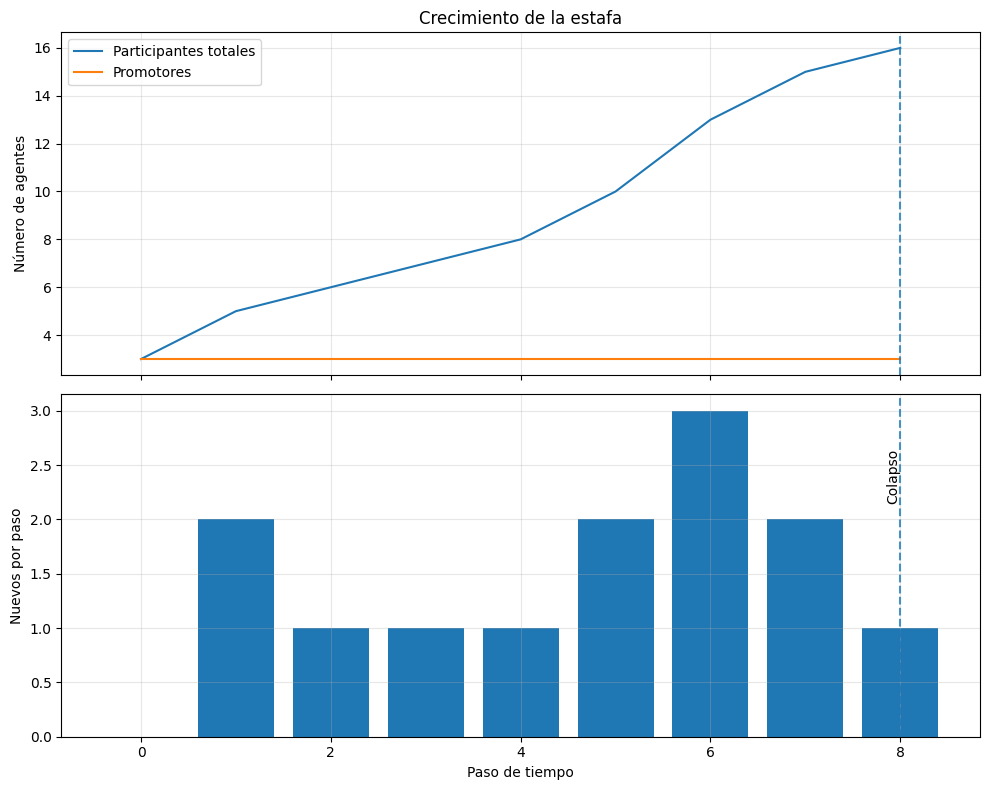

In [6]:
# Graficas de los resultados

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

t = history["t"]

# 1) Tamaño de la estafa
axes[0].plot(t, history["n_participantes"], label="Participantes totales")
axes[0].plot(t, history["n_promotores"], label="Promotores")
axes[0].set_ylabel("Número de agentes")
axes[0].set_title("Crecimiento de la estafa")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2) Flujo de nuevos inversores y colapso
axes[1].bar(t, history["n_nuevos"], label="Nuevos participantes por paso")
axes[1].set_ylabel("Nuevos por paso")
axes[1].set_xlabel("Paso de tiempo")
axes[1].grid(True, alpha=0.3)

# Marcar momento de colapso (si ocurrió)
if any(history["colapsado"]):
    t_colapso = next(tt for tt, c in zip(t, history["colapsado"]) if c)
    for ax in axes:
        ax.axvline(t_colapso, linestyle="--", alpha=0.8)
    axes[1].text(t_colapso, max(history["n_nuevos"] + [1]) * 0.8,
                 "Colapso", rotation=90, va="center", ha="right")

plt.tight_layout()
plt.show()

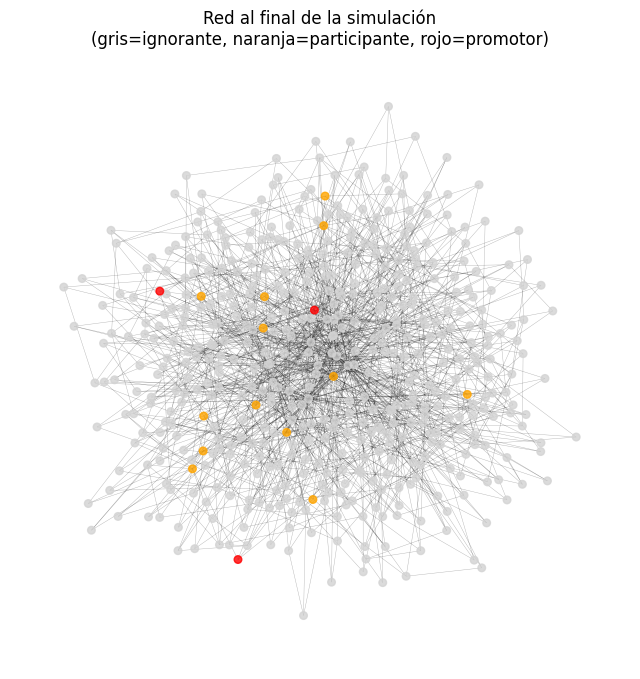

In [ ]:
# ESTO SE VE COMO MUCHO SPAM Y NO SE SI DEJARLO XD

# Visualización final de la red
color_map = []
for n, a in G.nodes(data=True):
    if a["estado"] == "ignorante":
        color_map.append("lightgray")
    elif a["estado"] == "participante":
        color_map.append("orange")
    elif a["estado"] == "promotor":
        color_map.append("red")
    else:
        color_map.append("black")

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)

plt.title("Red al final de la simulación\n(gris=ignorante, naranja=participante, rojo=promotor)")
plt.axis("off")
plt.show()